# Lab Sheet 5 (COM3502-4502-6502 Speech Processing)

This lab sheet is part of the lecture COM[3502](http://www.dcs.shef.ac.uk/intranet/teaching/public/modules/level3/com3502.html "Open web page for COM3502 module")-[4502](http://www.dcs.shef.ac.uk/intranet/teaching/public/modules/level4/com4502.html "Open web page for COM4502 module")-[6502](http://www.dcs.shef.ac.uk/intranet/teaching/public/modules/msc/com6502.html "Open web page for COM4502 module") Speech Processing at the [University of Sheffield](https://www.sheffield.ac.uk/ "Open web page of The University of Sheffield"), Dept. of [Computer Science](https://www.sheffield.ac.uk/dcs "Open web page of Department of Computer Science, University of Sheffield").

It is probably easiest to open this Jupyter Notebook with [Google Colab](https://colab.research.google.com/notebooks/intro.ipynb#recent=true "Open in Google Colab") since GitHub's Viewer does not always show all details correctly. <a href="https://colab.research.google.com/github/sap-shef/SpeechProcesssingLab/blob/main/Lab-Sheets/Lab-Sheet-5.ipynb"><img align="right" src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open Notebook in Google Colab" title="Open and Execute the Notebook directly in Google Colaboratory"></a>

Please put questions, comments and correction suggestions in the [Blackboard](https://vle.shef.ac.uk) discussion board or send an email to [s.goetze@sheffield.ac.uk](mailto:s.goetze@sheffield.ac.uk).

In [ ]:
# Let's do the ususal necessary and nice-to-have imports
%matplotlib inline
import matplotlib.pyplot as plt  # plotting
import seaborn as sns; sns.set() # styling ((un-)comment if you want)
import numpy as np               # math

## Loading a Speech File

Let's download a wave file containing speech:

In [ ]:
# download speech and noise example files
s_file_name = 'speech_8kHz_murder.wav'
!curl https://staffwww.dcs.shef.ac.uk/people/S.Goetze/sound/{s_file_name} -o {s_file_name} 

As done before several times by now, we can load the file from hard-disc to a variable and play it back (if we like).

In [ ]:
import soundfile as sf
from IPython import display as ipd

# load speech wave into variable
s, fs = sf.read(s_file_name)

print('File "' + s_file_name + '" loaded. Its sampling rate is ' + str(fs) + ' Hz.')

# listen to the sound file (if you want)
ipd.Audio(s, rate=fs)

## Spectrogram

The spectrogram can be used to visualise time and frequency information at the same time.

### Frequency Resolution vs. Time Resolution

The `specgram()` command from `matplotlib` has optional parameters, e.g. for the FFT length. Have a look at the [documentation](https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.specgram.html) to familarise yourself with the parameters.

<br>
<div style="border: 2px solid #999; padding: 10px; background: #eee;">
    
**Task 1:**
    
Create spectrograms of the speech signal `s` in different spectral and temporal resolution varying the parameters `NFFT` and `noverlap` of `matplotlib`'s `specgram()` command. 
    
</div>

In [ ]:
# your code here
# ...


## Filtering by Piecewise Linear Filters

We want to design digital filters in the following as depited below:

<img src="https://staffwww.dcs.shef.ac.uk/people/S.Goetze/book/Chp2Fundamentals/images/FilteringIIRfilter-web.svg" align="center"/>


This can be described mathematically by the difference equation for recursive filters 

\begin{equation}
y[k] = \sum_{m=0}^{q} b_m \; x[k-m] + \sum_{n=1}^{p} a_n \; y[k-n].
\end{equation}


### Tolerance Scheme

We want to design a piece-wise linear filter, such as a low-pass, band-pass, high-pass or similar, such filter shall at least fullfill the following conditions

*   It should be 1 or close to one in the pass-band area
*   It should be zero or close to zero in the stop band area

The following function `plot_tolerance_scheme()` is a helper function which visualises such a tolerance scheme.  

In [ ]:
def plot_tolerance_scheme(Wp=0.25,Ws=0.3,Rp_lin=0.9,Rs_lin=0.1):
    """
    Plots a tolerance scheme for a (low-pass) filter design.
    
    Parameters
    ----------
    Wp : float, optional (but recommended)
        pass limit frequency (normalised) $W_p = \Omega / \pi$
    Ws : float, optional (but recommended)
        stop limit frequency (normalised)
    Rp_lin : float, optional (but recommended)
        allowed ripple range in pass band (linear), default 0.9
    Rs_lin : float, optional (but recommended)
        allowed ripple range in pass band (linear), default 0.1

    Example use:
    -------
    signal
        plot_tolerance_scheme(Wp=0.25,Ws=0.3,Rp_lin=0.9,Rs_lin=0.1)
    """
    dh1x=[0,Ws];  dh1y=[1,1];            # (x,y) coordinates of lines
    dh2x=[0,Wp];  dh2y=[Rp_lin,Rp_lin]; 
    dv2x=[Wp,Wp]; dv2y=[0,Rp_lin];   
    sh1x=[Ws,1];  sh1y=[Rs_lin,Rs_lin]; 
    sh2x=[Wp,1];  sh2y=[0,0]; 
    svx=[Ws,Ws];  svy=[Rs_lin,1];  
    # plot the actual lines
    plt.plot(dh1x,dh1y,'k--',dh2x,dh2y,'k--',dv2x,dv2y,'k--',sh1x,sh1y,'k--',
             sh2x,sh2y,'k--',svx,svy,'k--');
    plt.xlabel('Frequency $\Omega/\pi$');

The following conditions are visualised in the tolerance scheme below for the exmample values $W_p=0.25$, $W_s=0.3$, and allowing for 10% ripples both in stop band area as in pass band area. 

The allowed tolerance is the pass-band area is defined by the parameter `Rp_lin`, and allowed tolerance is the stop-band area by `Rs_lin`. Please note, that they have the ending `..._lin` since we will need these quantities later in logarithmic scaling (we will care for this then).

In [ ]:
Wp=0.25;    # passband edge frequency 
Ws=0.3;     # stopband edge frequency 
Rp_lin=0.9; # allowed ripples in the pass band area
Rs_lin=0.1; # allowed ripples in the stop band area

plot_tolerance_scheme(Wp,Ws,Rp_lin,Rs_lin)

Please note that the low pass tolerance scheme is given in terms of normalised frequency $\Omega$.

As a reminder, we are already familiar with three different notations for the frequency, i.e. 
* the technical frequency $f$ in Hz, which for ditital signals and systems should be bound by half of the sampling frequency $f_s$ to fullfil the [Nyquist-Shannon Theorem](https://en.wikipedia.org/wiki/Nyquist%E2%80%93Shannon_sampling_theorem) to avoid [aliasing](https://en.wikipedia.org/wiki/Aliasing), i.e. $-\frac{f_s}{2} \leq f \leq \frac{f_s}{2}$
* the [angular frequency](https://en.wikipedia.org/wiki/Angular_frequency) $\omega = 2 \pi f$ 
* the [normalised frequency](https://en.wikipedia.org/wiki/Normalized_frequency_(unit)) $\Omega = \frac{\omega}{f_s} = 2 \pi \frac{f}{f_s}$ which is then bound by $0 \leq \Omega \leq 2 \pi$ or, since the frequency response is periodic for digital signals, $- \pi \leq \Omega \leq \pi$.

The parameters $W_p$ and $W_s$ are closely related to the normalised frequency $\Omega$, i.e. for $W_p=0.25$ it results in $\Omega_p=0.25 \pi$.

<br>
<div style="border: 2px solid #999; padding: 10px; background: #eee;">
    
**Task 2:**

Generate a tolerance scheme for a low-pass which should let pass half of the frequency region between $f=0$ and $f_{\mathrm{max}}=4000$ Hz and allows ripples of $5 \%$ as well for pass-band as in stop-band.
    
</div>

In [ ]:
# your code here
#
# ...

### Zero-Pole Plot (Transfer Functuon of Filters in z-Domain)

Applying a $z$-transform to the difference equation $z$-domain transfer function $H[z]$ of the filter leads to

\begin{equation}
H[z] = \frac{Y[z]}{X[z]} = \frac{\sum_{m=0}^{M} b_m \, z^{-m}}{\sum_{n=0}^{N} a_n \, z^{-n}}
\end{equation}

The transfer function can also be extpressed in term of the positions of its $P$ zeros $z_{0,\mu}$, ($1 \leq \mu \leq P$) and  its $Q$ poles $z_{\infty,\nu}$, ($1 \leq \nu \leq Q$). 


\begin{equation}
H[z] = \frac{b_M}{a_N} \cdot \frac{\prod_{\mu=1}^{P} (z - z_{0,\mu})^{m_\mu}}{\prod_{\nu=1}^{Q} (z - z_{\infty,\nu})^{n_\nu}}
\end{equation}

For speech and audio processing, systems often have real-valued coefficients $b_m\in\mathbb{R}$ and $a_n\in\mathbb{R}$ which results in a real-valued system. For real-valued systems, poles and zeros are either real valued or occur in complex conjugate pairs.

For the poles of a *causal* and *stable* system $H(z)$ all poles have to lie within the unit circle, i.e. $|z| = 1$. 

The following code implements another helper-function `zplane()` which plots poles and zeros in the complex $z$-plane.

In [ ]:
def zplane(z, p, title='Poles and Zeros'):
    "Plots zeros and poles in the complex z-plane"
    ax = plt.gca()

    ax.plot(np.real(z), np.imag(z), 'bo', fillstyle='none', ms=10)
    ax.plot(np.real(p), np.imag(p), 'rx', fillstyle='none', ms=10)
    unit_circle = plt.Circle((0, 0), radius=1, fill=False,
                             color='black', ls='--', alpha=0.9)
    ax.add_patch(unit_circle)

    plt.title(title)
    plt.xlabel('Re{$z$}')
    plt.ylabel('Im{$z$}')
    plt.axis('equal')

The code below exemplarily shows two (comjugate complex) zeros at positions $z_{0,1}= -0.9$ and $z_{0,2} = 0.8$ (indicated by the blue circles) as well as a poles at positions $z_{\infty,1}=0.5 + 0.5j$ and $z_{\infty,2}=0.5 - 0.5j$ (indicated by the red crosses)  in the $z$ plane. The code above is a helper-function to plot the zeros and poles.

In [ ]:
poles = [0.5-0.5j, 0.5+0.5j] # two (comjugate complex) poles
zeros = [-0.9, 0.8]          # two (real-valued) zeros
zplane(zeros,poles)

### Butterworth Filter Design

To actually design a filter we can use then function `butter()` from `scipy`'s `signal` libary which calculates filter coefficients $a_n$ and $b_m$. 

To ensure that our tolerace scheme is fullfilled we have to know, how many coefficients $a_n$, for $0 \leq n \leq p$ and $b_m$, for $0 \leq m \leq q$ (as defined below the schematic depicted at the top of this Notebook) the `butter()` method needs to achieve this. If we assume to have as many coefficients forward coefficients $b_m$ as feedback path coefficients $a_n$, i.e. $p=q$ we define the order of the filter as being $p$ (or $q$). The function `buttord()` takes our tolerance scheme (values) and calculates to required filter order $N$. Furthermore, the function `buttord()` returns the [cut-off frequnecy](https://en.wikipedia.org/wiki/Cutoff_frequency) of the filter, a.k.a. natural frequency and therefore the variable name `Wn` is used below (if we would denote this frequency by $f_c$ this would lead to confusion with the center frequency $f_c$. The cut-off frequency is defined as the frequency at which the frequency response is decayed by 3dB.

In [ ]:
from scipy import signal         # filter designs (if not already imported)

Wp=0.25;    # passband edge frequency 
Ws=0.3;     # stopband edge frequency 
Rp_lin=0.9; # allowed ripples in the pass band area
Rs_lin=0.1; # allowed ripples in the stop band area

# the ripple hights in dB are needed in later cells of this Jupyter Notebook 
Rp=-20*np.log10(Rp_lin);  # max passband ripple in dB
Rs=-20*np.log10(Rs_lin);  # min stopband attenuation in dB

# get lowest filter order N to fullfill requirements above
N, Wn = signal.buttord(Wp, Ws, Rp, Rs)

print('The minimum possible filter order to fulfil the tolerance scheme is '+str(N)+'.')

In [ ]:
# design low-pass filter of order N using butterworth method
b, a = signal.butter(N, Wn, 'low')

h=np.abs(np.fft.fft(b,1024))/np.abs(np.fft.fft(a,1024));
h=h[0:513] # only show first half (positive frequencies)
omega=np.linspace(0,1,513)

# plot frequency response
plot_tolerance_scheme()
plt.plot(omega, abs(h), lw=2)
plt.title('Butterworth low-pass filter of order ' + str(N))
plt.ylabel('Amplitude $|h(e^{j \Omega})|$');

The complex potions of the poles and zeros can be calculated using numpy's function `root()`. 

In [ ]:
# plot zeros and poles in the z plane
zplane(-1, np.roots(a))
plt.text(-0.95,0.1,'(15)');

<br>
<div style="border: 2px solid #999; padding: 10px; background: #eee;">
    
**Task 3:**
    
Create a butterwort filter fullfilling the tolerance scheme created for Task 2.
    
</div>

In [ ]:
# your code here
#
# ...

<br>
<div style="border: 2px solid #999; padding: 10px; background: #eee;">
    
**Task 4:**
    
Apply the filter you designed using the function `signal.filtfilt()`. Visualise the signal before and after filtering and plot the spectra.
    
</div>

In [ ]:
# your code here
#
# ...

### Chebyshev I and Chebyshev II filter design

Chebyshev filter designs make better use of the tolerance scheme by allowing for ripples in the pass band (Chebyshev I filter design) or stop band (Chebyshev II filter design), respectively. By this, the number of necessary filter coefficients $N$ can be reduced in comparison to the Butterworth filter.


<br>
<div style="border: 2px solid #999; padding: 10px; background: #eee;">
    
**Task 5:**
    
Design a Chebyshev I and Chebyshev II filter. You might find the functions `signal.cheb1ord()`, `signal.cheby2()`, `signal.cheb1ord()` and `signal.cheby2()` helpful for this.
    
</div>

In [ ]:
# your code here
#
# ...

### Cauer Filter a.k.a. Elliptical Filter Design

The number of necessary filter coefficients $N$ can be further reduced in comparison to the Butterworth, and Chebyshev I and II filters by allowing ripples in both, pass- and stop-band. This is done by the Cauer filter.

<br>
<div style="border: 2px solid #999; padding: 10px; background: #eee;">
    
**Task 6:**
    
Design a Cauer filter. You might find the functions `signal.ellipord()` and `signal.ellip()` helpful for this.
</div>


In [ ]:
# your code here
#
# ...

### Band pass and plotting in dB

Filters (especially for processing speech or music) are usually not only designed with logarithmic amplitude in mind, but also plotted with linear amplitude.

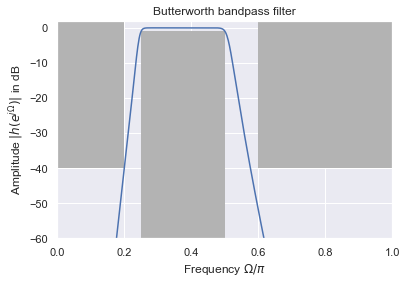

In [32]:
Wp = [0.25, 0.5]       # pass-band frequency limits (normalised)
Ws = [0.2,  0.6]       # stop-band frequency limits (normalised)
Rp = 1                 # we allow 1 dB ripple in pass-band
Rs = 40                # we's like to have 40dB attenuation
N, Wn = signal.buttord(Wp, Ws, Rp, Rs)
b, a = signal.butter(N, Wn, 'band')
f,h=signal.freqz(b,a)
omega=np.linspace(0,1,len(f))
plt.plot(omega, 20*np.log10(np.abs(h)))
plt.grid(True,which='both', axis='both')
plt.ylabel('Amplitude $|h(e^{j \Omega})|$ in dB')
plt.xlabel('Frequency $\Omega / \pi$')
plt.title('Butterworth bandpass filter')

plt.fill([0,     Ws[0],  Ws[0],   0],    [-Rs, -Rs, 2, 2], '0.7', lw=0) # stop
plt.fill([Wp[0], Wp[0],  Wp[1],  Wp[1]], [-100, -Rp, -Rp, -100], '0.7', lw=0) # pass
plt.fill([Ws[1], Ws[1], 1, 1],           [2, -Rs, -Rs, 2], '0.7', lw=0) # stop
plt.axis([0, 1, -60, 2]);

<br>
<div style="border: 2px solid #999; padding: 10px; background: #eee;">
    
**Task 7:**
    
Filter the signal by the bandpass designed above and listen to it. Again, you could visualise what you hear by using the spectrogram.
    
</div>

In [ ]:
# your code here
#
# ...

## Copyright

This notebook is licensed to be used during the lecture COM[3502](http://www.dcs.shef.ac.uk/intranet/teaching/public/modules/level3/com3502.html "Open web page for COM3502 module")-[4502](http://www.dcs.shef.ac.uk/intranet/teaching/public/modules/level4/com4502.html "Open web page for COM4502 module")-[6502](http://www.dcs.shef.ac.uk/intranet/teaching/public/modules/msc/com6502.html "Open web page for COM4502 module") Speech Processing at the [University of Sheffield](https://www.sheffield.ac.uk/ "Open web page of The University of Sheffield"), Dept. of [Computer Science](https://www.sheffield.ac.uk/dcs "Open web page of Department of Computer Science, University of Sheffield"). Any further use (beyond use for the lecture) is only permitted if agreed with the [module lead](mailto:s.goetze@sheffield.ac.uk). 